# Introduction

In this lab, we will learn how to use the **TargetEncoder** class from the Scikit-learn library. Target encoding is a technique used to transform categorical data into numerical data that can be used as input for machine learning algorithms. The **TargetEncoder** replaces each category of a categorical feature with the mean of the target variable for that category. This method is useful in cases where there is a strong relationship between the categorical feature and the target.

# Import Required Libraries

Next, we need to import the required libraries. Run the following code to import the required libraries:

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import KBinsDiscretizer, TargetEncoder
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Create Synthetic Dataset

For this lab, we will create a synthetic dataset with three categorical features: an informative feature with medium cardinality, an uninformative feature with medium cardinality, and an uninformative feature with high cardinality. We will use the **KBinsDiscretizer** class from Scikit-learn to generate the informative feature. Run the following code to create the synthetic dataset:

In [6]:
n_samples = 50_000

rng = np.random.RandomState(42)
y = rng.randn(n_samples)
noise = 0.5 * rng.randn(n_samples)
n_categories =100

kbins = KBinsDiscretizer(
    n_bins=n_categories, encode='ordinal', strategy='uniform', random_state=rng
)
X_informative = kbins.fit_transform((y + noise).reshape(-1, 1))

permuted_categories = rng.permutation(n_categories)
X_informative = permuted_categories[X_informative.astype(np.int32)]

X_shuffled =rng.permutation(X_informative)

X_near_unique_categories = rng.choice(
    int(0.9 * n_samples), size=n_samples, replace=True
).reshape(-1, 1)

X = pd.DataFrame(
    np.concatenate(
        [X_informative, X_shuffled, X_near_unique_categories],
        axis=1
    ),
    columns=['informative', 'shuffled', 'near_unique'],
)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Ridge Regressor on Raw Data

In this section, we will train a Ridge regressor on the dataset with and without encoding and explore the influence of target encoder with and without the interval cross-validation. First, we will train a Ridge model on the raw features. Run the following code to train the Ridge model:

In [3]:
ridge = Ridge(alpha=1e-6, solver='lsqr', fit_intercept=False)

raw_model = ridge.fit(X_train, y_train)
print('Raw Model score on training set: ', raw_model.score(X_train, y_train))
print('Raw Model score on test set:', raw_model.score(X_test, y_test))

Raw Model score on training set:  0.005179851658042134
Raw Model score on test set: 0.004938523369111492


# Train a Ridge Regressor with Cross Validation

Next, we will create a pipeline with the **TargetEncoder** and Ridge model. The pipeline uses **TargetEncoder.fit_transform** which uses cross-validation. Run the following code to train the Ridge model with cross-validation:

In [4]:
model_with_cv = make_pipeline(TargetEncoder(random_state=0), ridge)
model_with_cv.fit(X_train, y_train)
print("Model with CV on training set: ", model_with_cv.score(X_train, y_train))
print("Model with CV on test set: ", model_with_cv.score(X_test, y_test))

Model with CV on training set:  0.7981395425350759
Model with CV on test set:  0.797256705161917


# Evaluate the Coefficients of the Linear Model with Cross Validation


The coefficients of the linear model show that most of the weight is on the feature at column index 0, which is the informative feature. Run the following code to evaluate the coefficients of the linear model with cross-validation:

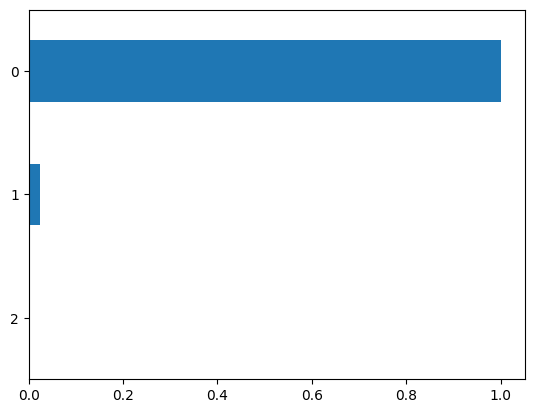

In [19]:
coefs_cv = pd.Series(
    model_with_cv[-1].coef_
).sort_values()
_ = coefs_cv.plot(kind="barh")

# Train a Ridge Regressor without Cross Validation

While **TargetEncoder.fit_transform** uses interval cross-validation, **TargetEncoder.transform** itself does not perform any cross-validation. It uses the aggregation of the complete training set to transform the categorical features. Thus, we can use **TargetEncoder.fit** followed by **TargetEncoder.transform** to disable the cross-validation. This encoding is then passed to the Ridge model. Run the following code to train the Ridge model without cross-validation:

In [20]:
target_encoder = TargetEncoder(random_state=0)
target_encoder.fit(X_train, y_train)
X_train_no_cv_encoding = target_encoder.transform(X_train)
X_test_no_cv_encoding = target_encoder.transform(X_test)

model_no_cv = ridge.fit(X_train_no_cv_encoding, y_train)
print(
    "Model without CV on training set: ",
    model_no_cv.score(X_train_no_cv_encoding, y_train),
)
print(
    "Model without CV on test set: ", model_no_cv.score(X_test_no_cv_encoding, y_test)
)

Model without CV on training set:  0.8545032800269341
Model without CV on test set:  0.6474579250382559


# Evaluate the Coefficients of the Linear Model without Cross ValidationEvaluate the Coefficients of the Linear Model without Cross Validation

The Ridge model overfits because it assigns more weight to the extremely high cardinality feature relative to the informative feature. Run the following code to evaluate the coefficients of the linear model without cross-validation:

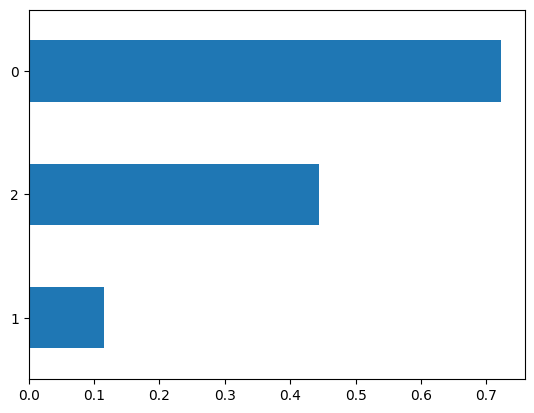

In [24]:
coefs_no_cv = pd.Series(
    model_no_cv.coef_
).sort_values()
_ = coefs_no_cv.plot(kind="barh")

# Summary

In this lab, we learned how to use the **TargetEncoder** class from Scikit-learn to transform categorical data into numerical data that can be used as input for machine learning algorithms. We also learned the importance of interval cross-validation in preventing overfitting. We trained a Ridge model on the raw data and evaluated its performance. We also trained a Ridge model with cross-validation and evaluated the coefficients of the linear model. Finally, we trained a Ridge model without cross-validation and evaluated the coefficients of the linear model.